In [ ]:
%matplotlib widget
import starepandas
import geopandas
import modreaders
import matplotlib.pyplot as plt
import pickle
#import spires
import numpy
import pandas
import scipy.io
import pystare
import time
import shapely.wkb
import postgis
import sqlalchemy
import contextily
import glob

In [ ]:
starepandas.__version__

In [4]:
user = 'spires_rw'
pwd = 'spiresrw'
host= 'localhost'
db_name = 'spires'
uri = f'postgresql+psycopg2://{user}:{pwd}@{host}/{db_name}'

engine = sqlalchemy.create_engine(uri)

In [5]:
# Reds Lake: 
x = 1373; y = 566

# Ned's favorite / Kamikaze Run
#x = 1374; y = 568

# Main Lodge
#x = 1380; y = 563

# McCoy / CUES
#x = 1379; y = 565

# Top Of Mammoth
#x = 1375; y = 568

In [ ]:
r0_files = sorted(glob.glob('/tablespace/spires/r0/r0_*.pickle'))

r0 = {}

for file_name in r0_files:    
    ds_name = file_name.split('/')[-1].split('r0_')[1].split('.pickle')[0]
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    r0[ds_name] = data

# Loading Data

## Loading ROI

In [7]:
with open('data/roi_4326_small.pickle', 'rb') as f:
    roi = pickle.load(f)
roi_sids = roi.sids.iloc[0]

## Loading Cells

In [ ]:
cells = postgis.read('cells', con=engine)

In [ ]:
cell_df = geopandas.GeoDataFrame(cells[(cells.x==x) & (cells.y==y)], geometry='polygons_4326', crs='4326')
cell = cell_df.to_dict(orient='records')[0]

## Load Ground-Truth (Subsetted worldview binary snowmap) 

In [ ]:
with open('/tablespace/spires/binary_snowmaps/2017-12-11_clippedDF.pickle', 'rb') as f:
    worldview = pickle.load(f)
worldview = worldview.replace(2, 0)

## Loading MOD09GA (Gridded)

In [ ]:
file_path = '/tablespace/spires/mod09ga/MOD09GA.A2017345.h08v05.006.2017347024314.hdf'
mod09ga = starepandas.read_granule(file_path, xy=True)

In [ ]:
mod09ga[(mod09ga.y>=551)& (mod09ga.y<=575) & (mod09ga.x>=1353) & (mod09ga.x<=1373)]

In [ ]:
mod09ga_cell = mod09ga[(mod09ga.x==x) & (mod09ga.y==y)]
mod09ga_cell

## Loading MOD09 from granule 

In [ ]:
def find_ifov(ifovs, spectrum):
    if isinstance(spectrum, pandas.core.frame.DataFrame):   
        spectrum = [spectrum['sur_refl_b01_1'], spectrum['sur_refl_b02_1'], spectrum['sur_refl_b03_1'], spectrum['sur_refl_b04_1'], 
                    spectrum['sur_refl_b05_1'], spectrum['sur_refl_b06_1'], spectrum['sur_refl_b07_1']]
    rows = ifovs[(numpy.isclose(ifovs['500m Surface Reflectance Band 1'], spectrum[0])) & 
                 (numpy.isclose(ifovs['500m Surface Reflectance Band 2'], spectrum[1])) & 
                 (numpy.isclose(ifovs['500m Surface Reflectance Band 3'], spectrum[2])) & 
                 (numpy.isclose(ifovs['500m Surface Reflectance Band 4'], spectrum[3])) & 
                 (numpy.isclose(ifovs['500m Surface Reflectance Band 5'], spectrum[4])) & 
                 (numpy.isclose(ifovs['500m Surface Reflectance Band 6'], spectrum[5])) & 
                 (numpy.isclose(ifovs['500m Surface Reflectance Band 7'], spectrum[6])) ]
    return rows

In [ ]:
file_path = '/tablespace/spires/mod09/MOD09.A2017345.1925.006.2017347015352.hdf'
mod09_granule = modreaders.read_mod09(file_path=file_path, roi_sids=roi_sids)
mod09_granule.set_geometry(geopandas.points_from_xy(mod09_granule.lon, mod09_granule.lat), crs=4326, inplace=True)

In [ ]:
fig = plt.figure(figsize=(3, 2), dpi=200)
ax = fig.add_subplot()

ax.plot(*cell['polygons_4326'].exterior.xy)
intersecting = mod09_granule[mod09_granule.stare_intersects(cell['buffer_sids_1000'])]
intersecting.plot(ax=ax, color='green', trixels=False)

selected = find_ifov(mod09_granule, mod09ga_cell)
selected.plot(ax=ax, trixels=False, color='red')

In [ ]:
def save_mod_df(df, filename):
    df = geopandas.GeoDataFrame(df)
    df.drop(columns=['state',  '500m Reflectance Band Quality', '1km Reflectance Data State QA'], errors='ignore').to_file(filename, driver='GPKG')

## Load all MOD09 data

In [ ]:
def add_ndvi(df):
    ndvi = (df['500m Surface Reflectance Band 2'] - df['500m Surface Reflectance Band 1'])/(df['500m Surface Reflectance Band 2'] + df['500m Surface Reflectance Band 1'])
    df['ndvi'] = ndvi
    
def add_ndsi(df):
    ndsi = (df['500m Surface Reflectance Band 4'] - df['500m Surface Reflectance Band 6'])/(df['500m Surface Reflectance Band 4'] + df['500m Surface Reflectance Band 6'])
    df['ndsi'] = ndsi

In [ ]:
with open('/tablespace/spires/mod09.pickle', 'rb') as f:
    mod09 = pickle.load(f)

add_ndsi(mod09)
add_ndvi(mod09)

In [ ]:
import copy
selected = copy.copy(find_ifov(mod09, mod09ga_cell))

# Create R0 libary

In [20]:
r0_library = mod09
r0_library = r0_library[r0_library['cloud_shadow']==False]
r0_library = r0_library[r0_library['cloud']==False]
r0_library = r0_library[r0_library['snow_mod35']==False]
r0_library = r0_library[r0_library['snow_internal']==False]
r0_library = r0_library[r0_library['ndsi']<0]
#r0_library = r0_library[r0_library['SensorZenith'] < 30]
#r0_library = r0_library[r0_library['500m Surface Reflectance Band 3'] > 0.1]

dt = pandas.to_datetime(r0_library['ts_start'])
#r0_library = r0_library[(dt.dt.month>5) & (dt.dt.month<10)]

r0_library.reset_index(inplace=True, drop=True)

## R0s that fall on same observation

In [33]:
sid = selected.to_stare_level(17).sids.iloc[0]
intersects = r0_library.to_stare_level(17).stare_intersects([sid])
r0_onpoint = r0_library[intersects].sort_values('scan_pos')

In [34]:
cell_df.set_geometry('polygons_4326', inplace=True)
r0_onpoint.set_geometry('center_point', inplace=True)
selected.set_geometry('center_point', inplace=True)

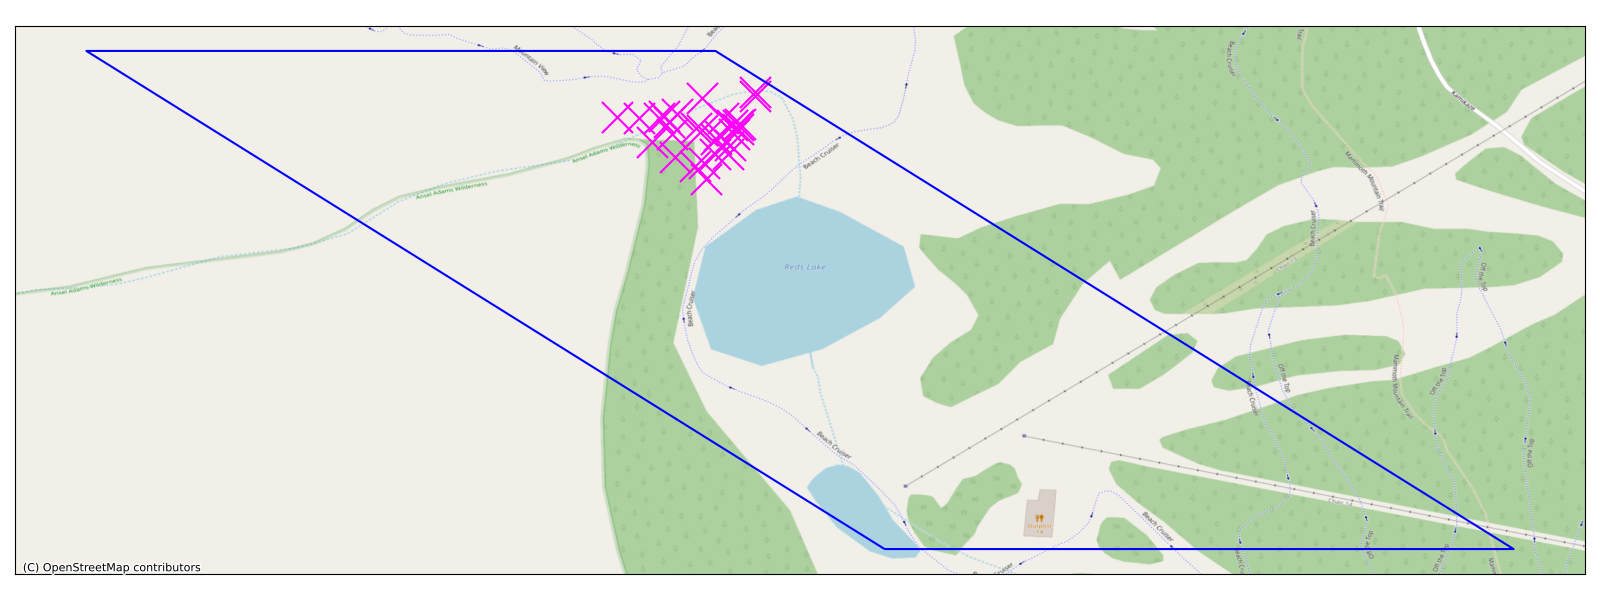

In [37]:
fig = plt.figure(figsize=(16, 6), dpi=100)
ax = fig.add_subplot()

plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

cell_df.exterior.plot(ax=ax, color='b', zorder=2)
r0_onpoint.plot(ax=ax, trixels=False, zorder=1, markersize=500, marker='x', color='magenta')
#selected.plot(ax=ax, trixels=False, zorder=1, markersize=500, marker='x', color='cyan')

contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, crs=4326)
fig.tight_layout()

In [38]:
r0_onpoint.set_geometry('center_point').geometry.to_file('ndvi_points.gpkg', driver='GPKG')

<AxesSubplot:xlabel='scan_pos'>

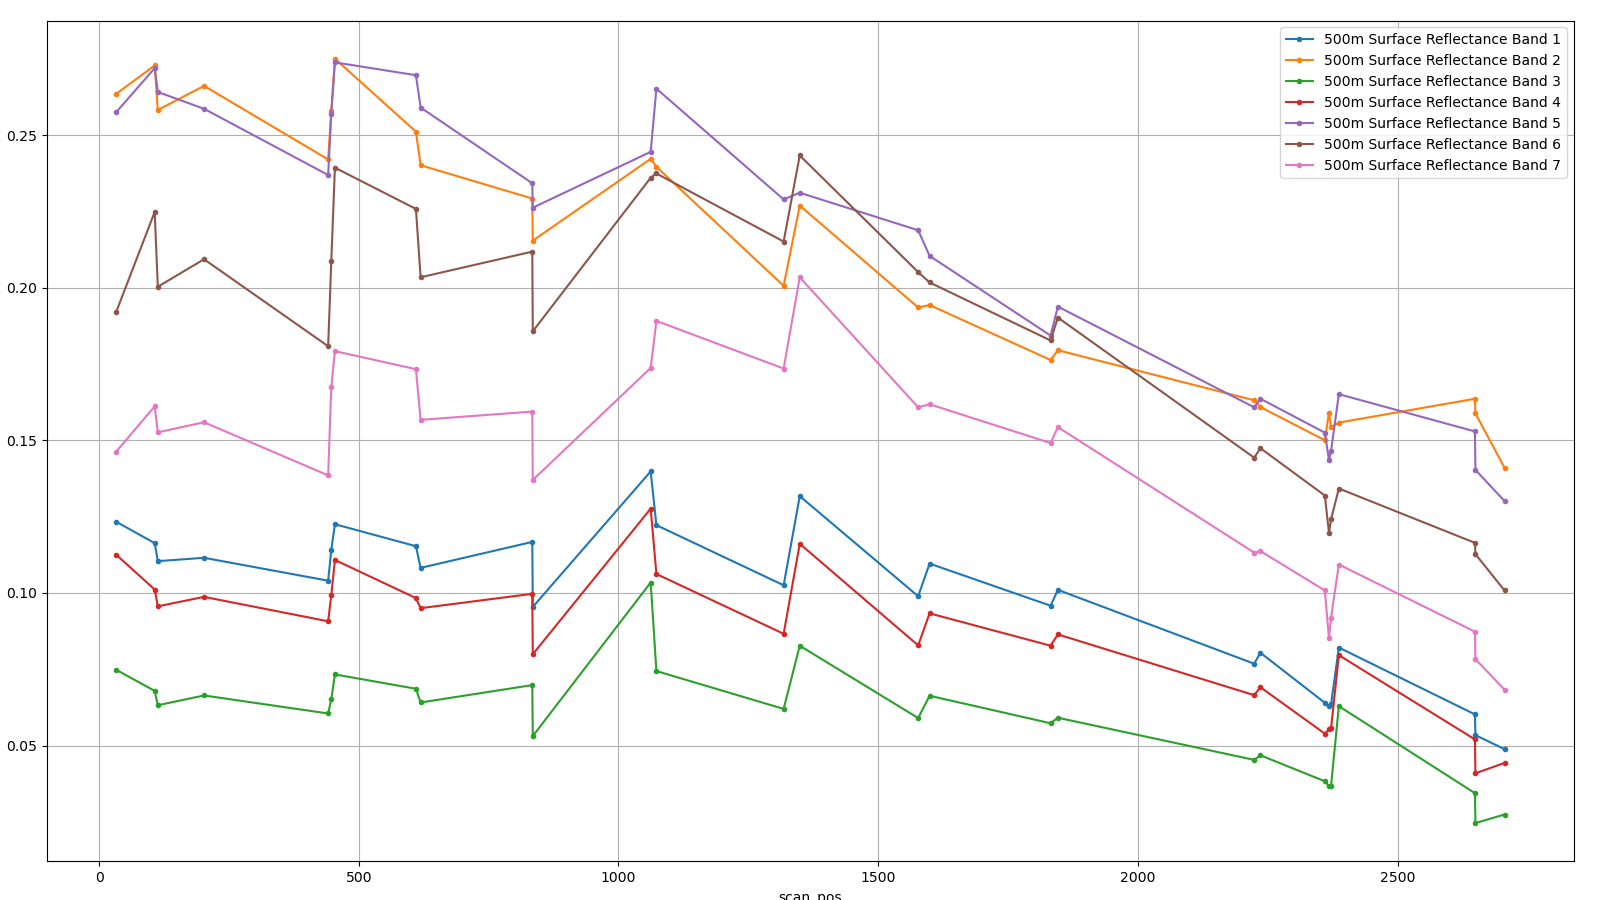

In [39]:
fig = plt.figure(figsize=(16, 9), dpi=100)
ax = fig.add_subplot()
fig.tight_layout()

x_axis = 'scan_pos'
y_axis = ['500m Surface Reflectance Band 1', '500m Surface Reflectance Band 2', '500m Surface Reflectance Band 3', 
          '500m Surface Reflectance Band 4', '500m Surface Reflectance Band 5', '500m Surface Reflectance Band 6', '500m Surface Reflectance Band 7']

r0_onpoint = r0_onpoint.sort_values(x_axis)
pandas.DataFrame(r0_onpoint).plot(x=x_axis, y=y_axis, ax=ax, grid=True, marker='.')

In [40]:
#sid = pystare.from_latlon([37.62600691422575], [-119.03900649128829], level=17) #creek
#sid = pystare.from_latlon([37.623934838741974], [-119.02511013281583], level=17) #Dragon

#sid = pystare.from_latlon([37.612298635885914], [-118.99655376170831], level=17) #  rock
sid = pystare.from_latlon([37.62255106589664], [-119.00785780041357], level=17) # Twin


intersects = r0_library.to_stare_level(17).stare_intersects(sid, n_partitions=32)
r0_onpoint = r0_library[intersects].sort_values('scan_pos')

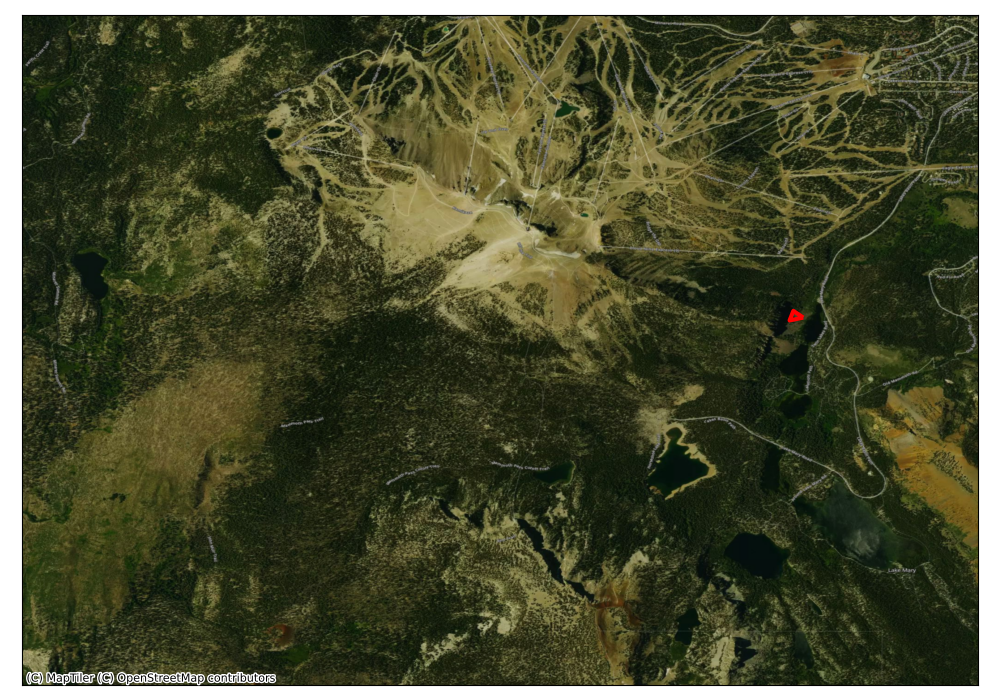

In [26]:
fig = plt.figure(figsize=(10, 7), dpi=100)
ax = fig.add_subplot()

plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

sdf = starepandas.STAREDataFrame(sids=sid)
sdf.add_trixels().plot(ax=ax, color='red', linewidth=3)
sdf.to_stare_level(11).add_trixels().plot(ax=ax, linewidth=0)

p = contextily.providers.MapTiler.Hybrid(key='s2uAyyJ4WmUzIH8OdujS')
contextily.add_basemap(ax, source=p, crs=4326)
#contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, crs=4326)
fig.tight_layout()

Text(0.5, 40.44444444444443, 'Along-scan position')

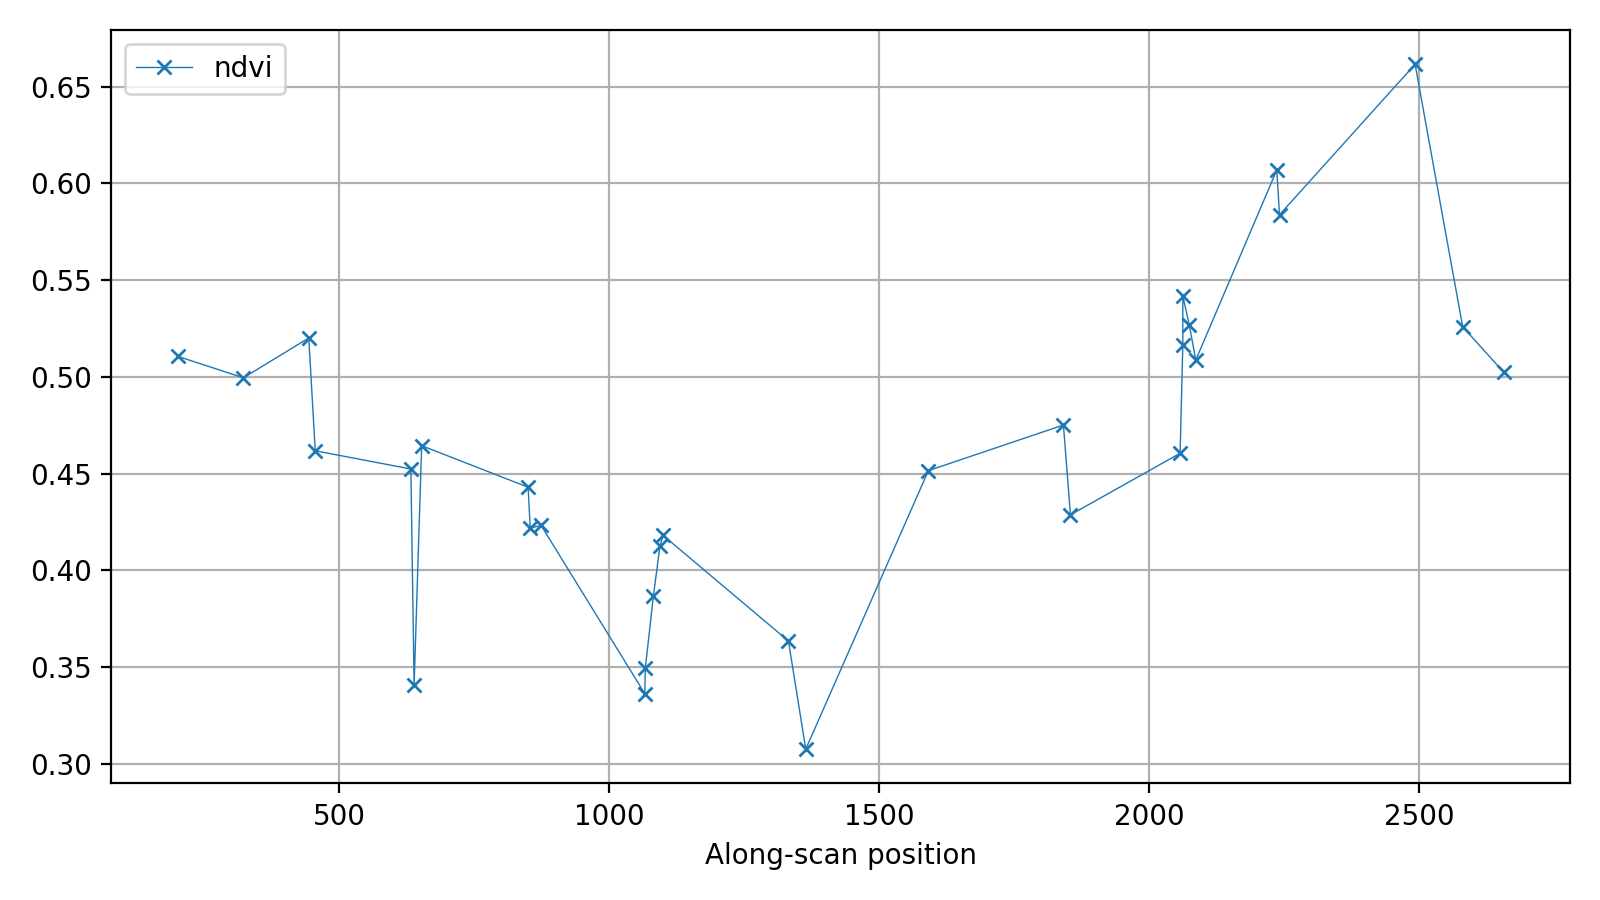

In [27]:
fig = plt.figure(figsize=(8, 4.5), dpi=200)
ax = fig.add_subplot()

x_axis = 'scan_pos'

pandas.DataFrame(r0_onpoint).plot(x=x_axis, y='ndvi', marker='x', ax=ax, grid=True, linewidth=0.5, markersize=5)
fig.tight_layout()
ax.set_xlabel('Along-scan position')
#pandas.DataFrame(r0_onpoint).plot(x=x_axis, y='ndsi', marker='.', ax=ax, grid=True)

## R0 that fall in cell

In [1]:
intersects = r0_library.set_sids('sids17').stare_intersects(cell['sids_buffer_250'])
r0_cell = r0_library[intersects]

x_axis = 'y'
y_axis = ['500m Surface Reflectance Band 1', '500m Surface Reflectance Band 2', '500m Surface Reflectance Band 3', 
          '500m Surface Reflectance Band 4', '500m Surface Reflectance Band 5', '500m Surface Reflectance Band 6', '500m Surface Reflectance Band 7']

r0_cell = r0_cell.sort_values(x_axis)

NameError: name 'r0_library' is not defined

## R0 Timbo

In [ ]:
r0_grid_raw = scipy.io.loadmat('data/h08v05_R0.mat')['R0']

In [ ]:
rows, cols = numpy.meshgrid(numpy.arange(2400, dtype='int32'), numpy.arange(2400, dtype='int32'), copy=False)
r0_grid = pandas.DataFrame(r0_grid_raw.reshape(2400*2400, 7), columns=['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1', 'sur_refl_b07_1'])
r0_grid['x'] = rows.flatten()
r0_grid['y'] = cols.flatten()

# Convert to GPGK
df = []
for index, row in r0_grid[(r0_grid.y.between(552, 575)) & (r0_grid.x.between(1354, 1401))].iterrows():
    r = starepandas.STAREDataFrame(find_ifov(r0_library, row))
    if r.size>0:
        r['ix'] = row.x
        r['iy'] = row.y
    df.append(r)
df = geopandas.GeoDataFrame(pandas.concat(df))
save_mod_df(df, 'r0_timbo.gpkg')

# Run spires

## Load R0 for tile

In [285]:
lut = spires.load_lut('data/LUT_MODIS.mat')

In [288]:
r0_timbo = r0_grid[(r0_grid.x==x) & (r0_grid.y==y)]
r0_timbo = find_ifov(r0_library, r0_timbo)

r0_timbo[['ts_start', 'x', 'y', 'SensorZenith', 'SolarZenith', 'cloud', 'cloud_shadow', '500m Surface Reflectance Band 3','ndvi', 'ndsi']]

Empty STAREDataFrame
Columns: [ts_start, x, y, SensorZenith, SolarZenith, cloud, cloud_shadow, 500m Surface Reflectance Band 3, ndvi, ndsi]
Index: []

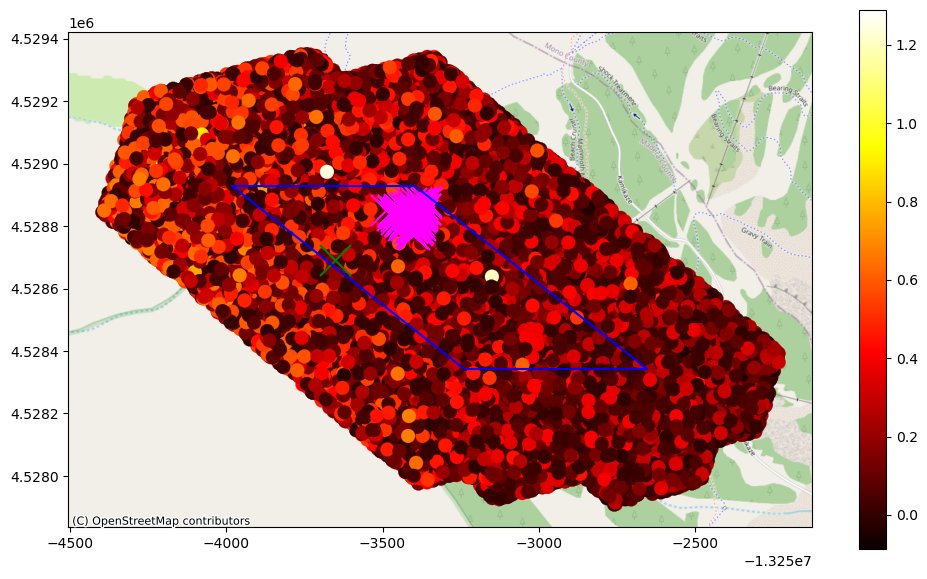

In [35]:
fig = plt.figure(figsize=(12, 7), dpi=100)
ax = fig.add_subplot()

cell_df.exterior.to_crs(epsg=3857).plot(ax=ax, color='b', zorder=2)
r0_cell.to_crs(epsg=3857).plot(ax=ax, zorder=1, linewidth=0.2, column='ndvi', legend=True, cmap='hot', trixels=False, markersize=100)
selected.to_crs(epsg=3857).plot(ax=ax, trixels=False, zorder=1, markersize=500, marker='x', color='cyan')

r0_onpoint.to_crs(epsg=3857).plot(ax=ax, trixels=False, zorder=1, markersize=500, marker='x', color='magenta')
r0_timbo.to_crs(epsg=3857).plot(ax=ax, trixels=False, zorder=1, markersize=500, marker='x', color='green')

contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik)

## Run spires

In [36]:
def spectrum(df):    
    spectrum = df[['500m Surface Reflectance Band 1', 
                   '500m Surface Reflectance Band 2',
                   '500m Surface Reflectance Band 3',
                   '500m Surface Reflectance Band 4',
                   '500m Surface Reflectance Band 5',
                   '500m Surface Reflectance Band 6',
                   '500m Surface Reflectance Band 7']].to_numpy()
    return spectrum

In [37]:
solar_z = selected['SolarZenith'].iloc[0]
shade = numpy.zeros(7)

## Getting fSCA for every R0

In [38]:
r_spectrum = spectrum(selected)[0]

In [39]:
results = []
for index, row in r0_cell.iterrows():
    r0_spectrum = spectrum(row)
    res, model_refl = spires.speedy_invert(lut, r_spectrum, r0_spectrum, solar_z, shade, mode=4)
    results.append({'index': index, 'fsca': res.x[0],'fshade': res.x[1], 'rg': res.x[2], 'dust': res.x[3]})
results = geopandas.GeoDataFrame(pandas.DataFrame(results).set_index('index').join(r0_cell), geometry='geometry')

KeyboardInterrupt: 

In [ ]:
pandas.set_option('display.max_rows', 10)
results[['fsca', 'fshade', 'rg', 'dust', 'ts_start', 'y', 'SensorZenith', 'SolarZenith', 'cloud', 'cloud_shadow', '500m Surface Reflectance Band 3','ndvi', 'ndsi']].sort_values('fsca')